In [2]:
#!pip install transformers
#!pip install datasets

In [3]:
#from google.colab import drive
#drive.mount('/content/drive')

In [1]:
import pandas as pd
import os
import numpy as np
from transformers import AutoConfig, create_optimizer, TFAutoModelForSequenceClassification, AutoModelForSequenceClassification
from transformers import DefaultDataCollator
import tensorflow as tf
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
from datasets import load_dataset
import datasets
import pickle

2022-06-09 15:46:17.784339: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


In [2]:
path = "../data/processed_data/"
data_files = {"train": os.path.join(path,"training_set.pkl"), "validation":os.path.join(path,"validation_set.pkl"), "test":os.path.join(path,"test_set.pkl")}
dataset = load_dataset("pandas", data_files=data_files)

with open(os.path.join(path,"tokenize_table.pkl"), 'rb') as f:
    tok = pickle.load(f)

print("number of unique tokens in the data: ", len(tok.keys()))

Using custom data configuration default-3f3136a434948713
Reusing dataset pandas (/gxfs_home/cau/sunam188/.cache/huggingface/datasets/pandas/default-3f3136a434948713/0.0.0/6197c1e855b639d75a767140856841a562b7a71d129104973fe1962594877ade)


  0%|          | 0/3 [00:00<?, ?it/s]

number of unique tokens in the data:  32634


In [3]:
def compute_sequence_label(example):
    return {"sequence_label": 1 if 1 in example["labels"] else 0}

dataset = dataset.map(compute_sequence_label)
dataset = dataset.remove_columns(['origin', 'chunk','set', 'tokens','labels', '__index_level_0__'])
dataset = dataset.rename_column("sequence_label", "labels")
dataset = dataset.rename_column("token_ids", "input_ids")
dataset = dataset.rename_column("attention_masks", "attention_mask")

Loading cached processed dataset at /gxfs_home/cau/sunam188/.cache/huggingface/datasets/pandas/default-3f3136a434948713/0.0.0/6197c1e855b639d75a767140856841a562b7a71d129104973fe1962594877ade/cache-0ada1420a91849f1.arrow
Loading cached processed dataset at /gxfs_home/cau/sunam188/.cache/huggingface/datasets/pandas/default-3f3136a434948713/0.0.0/6197c1e855b639d75a767140856841a562b7a71d129104973fe1962594877ade/cache-ab16d0fcd60a93a6.arrow
Loading cached processed dataset at /gxfs_home/cau/sunam188/.cache/huggingface/datasets/pandas/default-3f3136a434948713/0.0.0/6197c1e855b639d75a767140856841a562b7a71d129104973fe1962594877ade/cache-9fb63651aaa6107e.arrow


In [4]:
dataset

DatasetDict({
    train: Dataset({
        features: ['input_ids', 'attention_mask', 'labels'],
        num_rows: 209159
    })
    validation: Dataset({
        features: ['input_ids', 'attention_mask', 'labels'],
        num_rows: 12736
    })
    test: Dataset({
        features: ['input_ids', 'attention_mask', 'labels'],
        num_rows: 12668
    })
})

In [8]:
data_collator = DefaultDataCollator(return_tensors="tf")

tf_train_dataset = dataset["train"].to_tf_dataset(
    columns=["attention_mask", "input_ids", "labels"],
    #label_cols=["labels"],
    shuffle=True,
    collate_fn=data_collator,
    batch_size=8,
)

tf_validation_dataset = dataset["validation"].to_tf_dataset(
    columns=["attention_mask", "input_ids", "labels"],
    #label_cols=["labels"],
    shuffle=False,
    collate_fn=data_collator,
    batch_size=8,
)

tf_test_dataset = dataset["test"].to_tf_dataset(
    columns=["attention_mask", "input_ids", "labels"],
    #label_cols=["labels"],
    shuffle=False,
    collate_fn=data_collator,
    batch_size=8,
)

In [ ]:
from datasets.dataset_dict import DatasetDict
from datasets import Dataset

d = {'train':Dataset.from_dict(tf),
     'val':Dataset.from_dict({'label':y_val,'text':x_val}),
     'test':Dataset.from_dict({'label':y_test,'text':x_test})
     }

DatasetDict(d)

In [17]:

checkpoint = "models/MLM_3"
model = TFAutoModelForSequenceClassification.from_pretrained(checkpoint, num_labels=2)
model.summary()

loading configuration file models/MLM_3/config.json
Model config DistilBertConfig {
  "_name_or_path": "models/MLM_3",
  "activation": "gelu",
  "architectures": [
    "DistilBertForMaskedLM"
  ],
  "attention_dropout": 0.1,
  "dim": 768,
  "dropout": 0.1,
  "hidden_dim": 3072,
  "initializer_range": 0.02,
  "max_position_embeddings": 150,
  "model_type": "distilbert",
  "n_heads": 12,
  "n_layers": 6,
  "pad_token_id": 0,
  "qa_dropout": 0.1,
  "seq_classif_dropout": 0.2,
  "sinusoidal_pos_embds": false,
  "tie_weights_": true,
  "transformers_version": "4.19.2",
  "vocab_size": 32645
}

loading weights file models/MLM_3/tf_model.h5
Some layers from the model checkpoint at models/MLM_3 were not used when initializing TFDistilBertForSequenceClassification: ['vocab_layer_norm', 'vocab_transform', 'vocab_projector']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. ini

Model: "tf_distil_bert_for_sequence_classification_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 distilbert (TFDistilBertMai  multiple                 67715328  
 nLayer)                                                         
                                                                 
 pre_classifier (Dense)      multiple                  590592    
                                                                 
 classifier (Dense)          multiple                  1538      
                                                                 
 dropout_59 (Dropout)        multiple                  0         
                                                                 
Total params: 68,307,458
Trainable params: 68,307,458
Non-trainable params: 0
_________________________________________________________________


In [19]:
model.load_tf_weights()

AttributeError: 'TFDistilBertForSequenceClassification' object has no attribute 'load_tf_weights'

In [10]:
from transformers import Trainer, TrainingArguments

args = TrainingArguments(
    output_dir="codeparrot-ds",
    per_device_train_batch_size=32,
    per_device_eval_batch_size=32,
    evaluation_strategy="steps",
    eval_steps=5_000,
    logging_steps=5_000,
    gradient_accumulation_steps=8,
    num_train_epochs=1,
    weight_decay=0.01,
    warmup_steps=1_000,
    lr_scheduler_type="cosine",
    learning_rate=5e-5,
    save_steps=5_000,
    fp16=True,
    push_to_hub=False,
)

trainer = Trainer(
    model=model,
    args=args,
    data_collator=data_collator,
    train_dataset=dataset["train"],
    eval_dataset=dataset["validation"],
)

AttributeError: 'TFDistilBertForSequenceClassification' object has no attribute 'to'

In [11]:
print(list(model.parameters()))

AttributeError: 'TFDistilBertForSequenceClassification' object has no attribute 'parameters'

In [16]:


model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=5e-5),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=tf.metrics.SparseCategoricalAccuracy(),
)


In [23]:
model.fit(tf_train_dataset, validation_data=tf_validation_dataset, epochs=2)

Epoch 1/2


TypeError: 'NoneType' object is not callable

In [ ]:
model.save_pretrained("drive/MyDrive/TE_detection/model2/")

# Evaluate Model

In [8]:
model_path = "drive/MyDrive/TE_detection/model2"
model = TFAutoModelForSequenceClassification.from_pretrained(model_path, num_labels=2)

All model checkpoint layers were used when initializing TFDistilBertForSequenceClassification.

All the layers of TFDistilBertForSequenceClassification were initialized from the model checkpoint at drive/MyDrive/TE_detection/model2.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFDistilBertForSequenceClassification for predictions without further training.


In [51]:
def get_predictions(tf_dataset, threshold):
    all_predictions = []
    all_labels = []

    for batch in tf_dataset:
        logits = model.predict(batch)["logits"]
        labels = batch["labels"]
        probs = tf.nn.softmax(logits)
        predictions = [int(prob) for prob in probs[:,1]>threshold]
        labels = [int(label) for label in labels==1]
        for prediction, label in zip(predictions, labels):
                all_predictions.append(prediction)
                all_labels.append(label)
    return all_predictions, all_labels

def compute_metrics(pred, labels):

    accuracy = accuracy_score(y_true=labels, y_pred=pred)
    recall = recall_score(y_true=labels, y_pred=pred)
    precision = precision_score(y_true=labels, y_pred=pred)
    f1 = f1_score(y_true=labels, y_pred=pred)
    cm = confusion_matrix(all_labels, all_predictions)
    cm_n = confusion_matrix(all_labels, all_predictions, normalize="true")

    return {"accuracy": accuracy, "precision": precision, "recall": recall, "f1": f1, "cm":cm, "cm_normalized":cm_n}

In [54]:
print(f'TEs in the data: {sum(dataset["test"]["labels"])/len(dataset["test"]["labels"])*100:.2f}%')

TEs in the data: 19.81%


Using threshold 0.5...

TEs in the data: 19.81%
Accuracy: 96.67


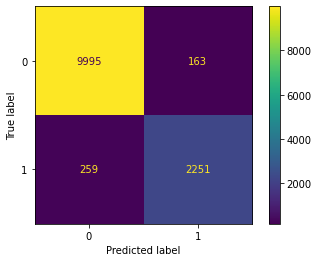

Accuracy:   96.67%
precision:  93.25%
recall:     89.68%
f1:         91.43%

Confusion matrix:
[[9995  163]
 [ 259 2251]]


In [52]:
# Threshold: 0.5
threshold = 0.5
print(f"Using threshold {threshold}...\n")
all_predictions, all_labels = get_predictions(tf_test_dataset, threshold)
metrics = compute_metrics(all_predictions, all_labels)

disp = ConfusionMatrixDisplay(metrics["cm"])
disp.plot()
plt.show()

print(f'Accuracy:   {metrics["accuracy"]*100:.2f}%')
print(f'precision:  {metrics["precision"]*100:.2f}%')
print(f'recall:     {metrics["recall"]*100:.2f}%')
print(f'f1:         {metrics["f1"]*100:.2f}%')
print(f'\nConfusion matrix:\n{metrics["cm"]}')

Using threshold 0.1...

TEs in the data: 19.81%
Accuracy: 96.61


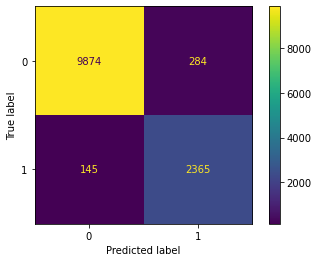

Accuracy:   96.61%
precision:  89.28%
recall:     94.22%
f1:         91.68%

Confusion matrix:
[[9874  284]
 [ 145 2365]]


In [53]:
# Threshold: 0.1
threshold = 0.1
print(f"Using threshold {threshold}...\n")

all_predictions, all_labels = get_predictions(tf_test_dataset, threshold)
metrics = compute_metrics(all_predictions, all_labels)

disp = ConfusionMatrixDisplay(metrics["cm"])
disp.plot()
plt.show()

print(f'Accuracy:   {metrics["accuracy"]*100:.2f}%')
print(f'precision:  {metrics["precision"]*100:.2f}%')
print(f'recall:     {metrics["recall"]*100:.2f}%')
print(f'f1:         {metrics["f1"]*100:.2f}%')
print(f'\nConfusion matrix:\n{metrics["cm"]}')